# Анализ продаж компьютерных игр для интернет-магазина

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Данные предоставлены по 2016 года. По легенде планируем кампанию на 2017-й. 

# <a name="contents">Содержание</a>
## [1. Ознакомление с данными и их предобработка](#stage_1)
- Общая информация.
- Поиск аномалий.
- Предобработка данных.      

## [2. Исследовательский анализ данных](#stage_2)
- Анализ динамики количества выпущенных игр в разные годы.
- Анализ количества выпущенных игр за последние 4 года.
- Анализ количества проданных экземпляров игр за последние 4 года.
- Определение самой перспективной платформы и жанра для закупки игр в 2017.
- Анализ влияния на продажи платформы отзывов пользователей и критиков.
- Составление портрета пользователя каждой из стран.
- Зависимость количества продаж и возрастного рейтинга в Северной Америке.
- Формулировка гипотез и их проверка.
    
    
## [3. Результаты исследования](#stage_3)
- Выводы.


<a name="stage_1"></a>
# 1. Ознакомление с данными и их предобработка.


[Наверх к оглавлению](#contents)

In [275]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(16, 8)})

import scipy.stats as st
import statsmodels.api as sm
import scikit_posthocs as sp

import warnings
warnings.simplefilter('ignore')

In [276]:
try:
    games = pd.read_csv(r'C:\Users\USER\Desktop\Обучение 2020\Яндекс Практикум\Project_games_sales\games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')

In [277]:
games

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


**Описание данных**

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [278]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


* `User_Score` необходимо перевести в числовой тип данных
* `Name` игры без указанного названия, такие нужно удалить (тем более, что их всего 2)
* В других столбцах тоже есть пропуски, но их слишком много, чтобы их можно было спокойно удалить.
* Приведем названия столбцов к нижнему регистру, для удобства работы в дальнейшем

In [279]:
# посмотрим на уникальные значения, возможно быстро найдем причину, 
# почему столбец автоматически не определилися как числовой тип данных
games['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

'tbd' значит 'To Be Determined', т.е. пока еще отценка не выставленна. Заменим такие значения на NaN

In [280]:
index_to_drop = games.query('User_Score == "tbd"').index
games['User_Score'] = games['User_Score'].drop(index = index_to_drop)

In [281]:
games['User_Score'] = games['User_Score'].apply(float)

In [282]:
games.dropna(subset=['Name'], inplace=True)

In [283]:
games = games.rename(columns = lambda x: x.lower())

In [284]:
# посмотрим на описательную статистику строковых данных
games[['name', 'platform', 'genre', 'rating']].describe(include='all')

,name,platform,genre,rating
count,16713,16713,16713,9949
unique,11559,31,12,8
top,Need for Speed: Most Wanted,PS2,Action,E
freq,12,2161,3369,3990


* Самая частоупоминаемая игра "Need for Speed: Most Wanted", изучим ее подробнее в следующем разделе
* 31 платформа для игр? Нужно проверить, есть ли столько платформ.
* Многим играм не присвоен рейтинг возрастной категории. Попробуем найти от чего это может зависеть.

In [285]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Существующих платформ действительно много.

In [286]:
# посмотрим на описательную статистику строковых данных для игр, с незаполненны рейтингом
games[games['rating'].isna()][['name', 'platform', 'genre', 'rating']].describe(include='all')

,name,platform,genre,rating
count,6764,6764,6764,0
unique,5852,31,12,0
top,FIFA 12,PS,Action,NaN
freq,7,989,1181,NaN


В статистике игр, с незаполненным рейтингом упоминаются как все платформы, так и все жанры, соответственно рейтинг зависит только от названия самой игры.

In [287]:
# посмотрим на описательную статистику числовых данных
games[['year_of_release' , 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score']].describe(include='all')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000,7590.000000
mean,2006.486256,0.263302,0.145045,0.077625,0.047343,68.967679,7.125046
std,5.875525,0.813565,0.503359,0.308871,0.186742,13.938165,1.500006
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


* Минимальный год 1980. Скорее всего тренды с тех пор изменились, в следующем разделе мы это проанализируем.
* `year_of_release` округлим значения (т.к. есть NaN полностью округлить не получится)
* `na_sales`, `eu_sales`, `jp_sales`, `other_sales` округлим значения до 2х знаков после запятой
* `critic_score`, `user_score` округлим до одного знака после запятой
* `critic_score`, `user_score` много пропущенных значений, но для анализа популярности можно использовать значение количества продаж
* Для удобства необходимо создать столбец с общим количеством продаж, во всех странах

In [288]:
games['year_of_release'] = games['year_of_release'].round(1)

In [289]:
games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].round(2)

In [290]:
games[['critic_score', 'user_score']] = games[['critic_score', 'user_score']].round(2)

In [291]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

<a name="stage_2"></a>
# 2. Исследовательский анализ данных.


[Наверх к оглавлению](#contents)

### Анализ динамики количества выпущенных игр в разные годы

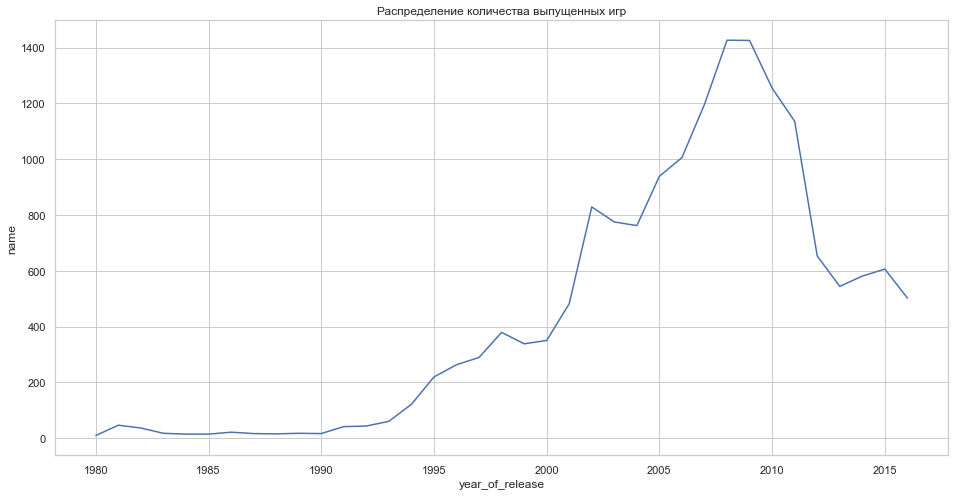

In [292]:
ax = sns.lineplot(data = games.groupby('year_of_release', as_index=False).name.count(),
              x = 'year_of_release',
              y = 'name')
ax.set_title('Распределение количества выпущенных игр')
plt.show()

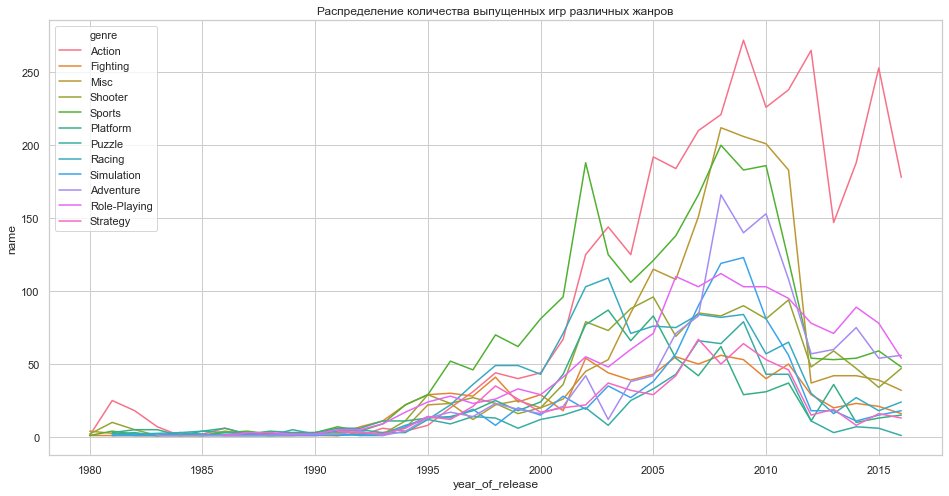

In [293]:
ax1 = sns.lineplot(data = games.groupby(['year_of_release', 'genre'], as_index=False).name.count(),
                  x = 'year_of_release',
                  y = 'name', 
                  hue = 'genre')
ax1.set_title('Распределение количества выпущенных игр различных жанров')
plt.show()

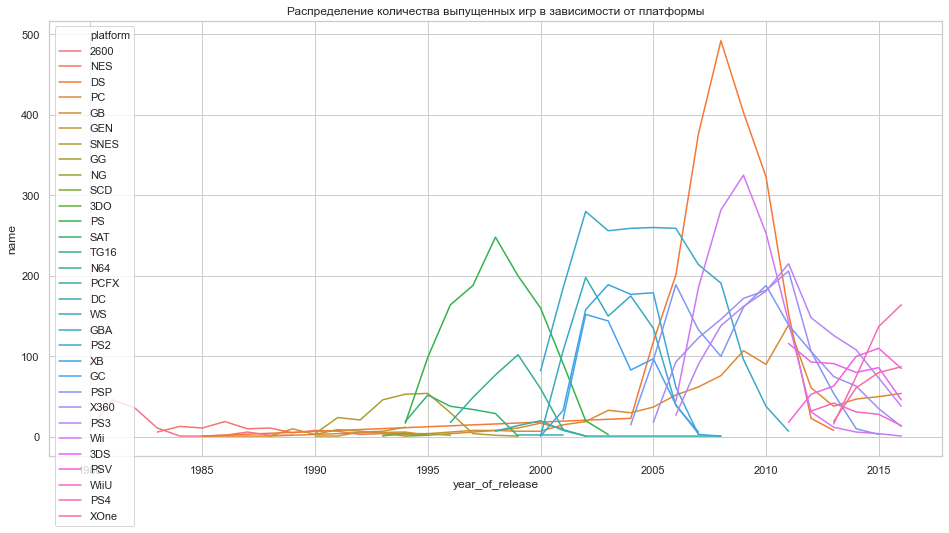

In [294]:
ax2 = sns.lineplot(data = games.groupby(['year_of_release', 'platform'], as_index=False).name.count(),
                  x = 'year_of_release',
                  y = 'name', 
                  hue = 'platform')
ax2.set_title('Распределение количества выпущенных игр в зависимости от платформы')
plt.show()

По графикам видно динамику выхода новых игр, в т.ч. в зависимости от жанров и платформ. Если смотреть на график *выхохода общего числа игр* и *выхода игр в зависимости от платформы*, то можно заметить относительную стабильность в последние 4 года (кроме игр жанра Action, этот жанр довольно-таки волатилен). Ну и в ообщем, можно сказать, что преобладание одних жанров над другими относительно стабильное. 

На графике *Распределения количества игр в зависимости от платформы* видно, что продолжительность выхода игр на платформах в среднем составляет от 8-10 лет, из которых половину срока платформа наращивает свои мощности, а вторую половину с такой же скоростью ее теряет. Из чего можно сделать вывод, что платформа набирает популярность в течении 4-5 лет.

### Анализ выпущенных игр за последние 4 года

In [295]:
# Для дальнейшего анализа будем использовать последние 4 года
years = [2013, 2014, 2015, 2016]
games_season = games.query("year_of_release in @years")

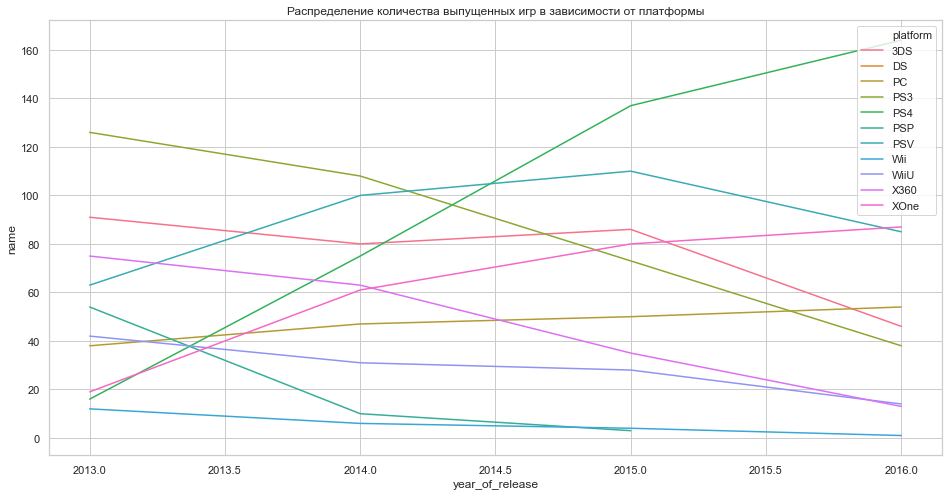

In [296]:
ax3 = sns.lineplot(data = games_season.groupby(['year_of_release', 'platform'], as_index=False).name.count(),
                  x = 'year_of_release',
                  y = 'name', 
                  hue = 'platform')
ax3.set_title('Распределение количества выпущенных игр в зависимости от платформы')
plt.show()

In [297]:
# посмотрим на 5 самых результативных платформ за последний год
games_season \
    .groupby(['year_of_release', 'platform'], as_index=False) \
    .name.count() \
    .sort_values(by=['year_of_release', 'name'], ascending = False) \
    .head(5)

,year_of_release,platform,name
34,2016.0,PS4,164
39,2016.0,XOne,87
35,2016.0,PSV,85
32,2016.0,PC,54
31,2016.0,3DS,46


На графике мы видим, что количество выпущенных игр имеет положительную тенденцию только на 3х платформах: `PS4`, `XOne` и `PC`. 

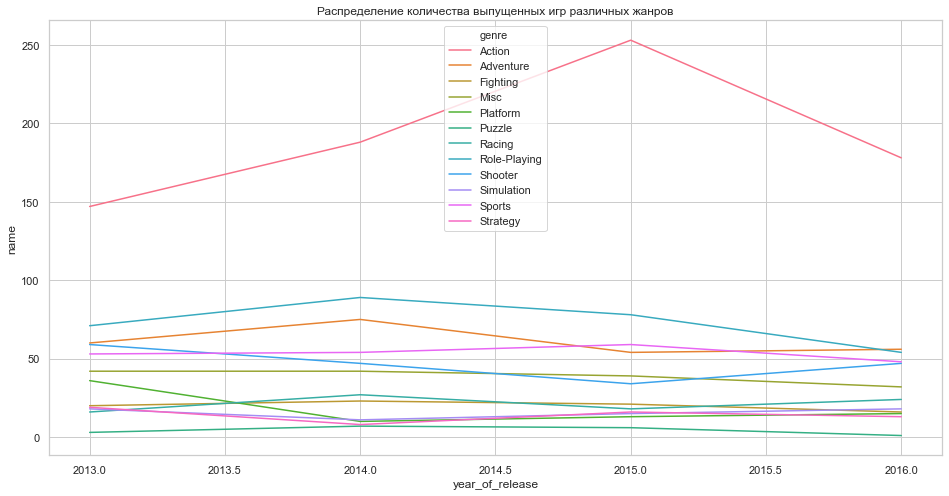

In [298]:
ax = sns.lineplot(data = games_season.groupby(['year_of_release', 'genre'], as_index=False).name.count(),
                  x = 'year_of_release',
                  y = 'name', 
                  hue = 'genre')
ax.set_title('Распределение количества выпущенных игр различных жанров')
plt.show()

In [299]:
# посмотрим на 10 самых результативных жанров за последний год
games_season \
    .groupby(['year_of_release', 'genre'], as_index=False) \
    .name.count() \
    .sort_values(by=['year_of_release', 'name'], ascending = False) \
    .head(10)

,year_of_release,genre,name
36,2016.0,Action,178
37,2016.0,Adventure,56
43,2016.0,Role-Playing,54
46,2016.0,Sports,48
44,2016.0,Shooter,47
39,2016.0,Misc,32
42,2016.0,Racing,24
45,2016.0,Simulation,18
38,2016.0,Fighting,16
40,2016.0,Platform,15


Видно, что самым популярным жанром является "Action"

### Анализ количества проданных экземпляров игр за последние 4 года

Посмотрим на ситуацию с количеством проданных экземпляров игр, ведь именно количество проданных экземпляров влияет на монетизацию.

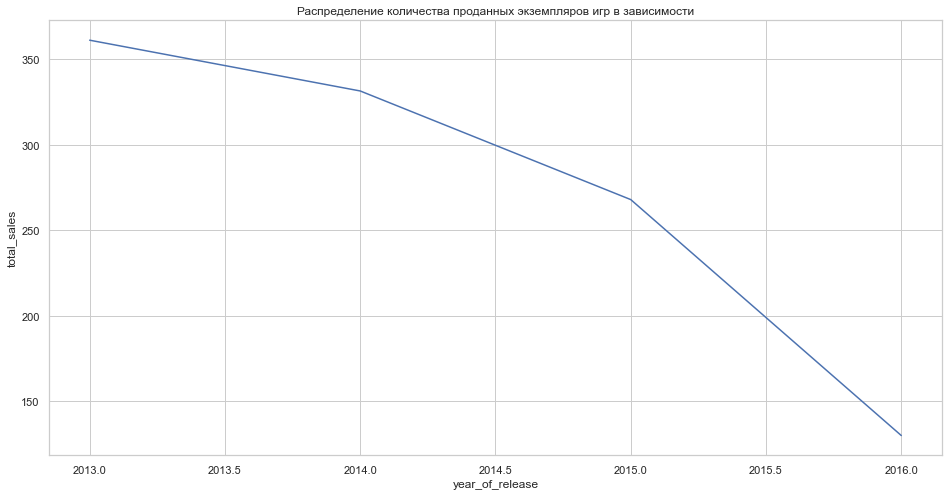

In [300]:
ax4 = sns.lineplot(data = games_season.groupby('year_of_release', as_index=False).total_sales.sum(),
              x = 'year_of_release',
              y = 'total_sales')
ax4.set_title('Распределение количества проданных экземпляров игр в зависимости')
plt.show()

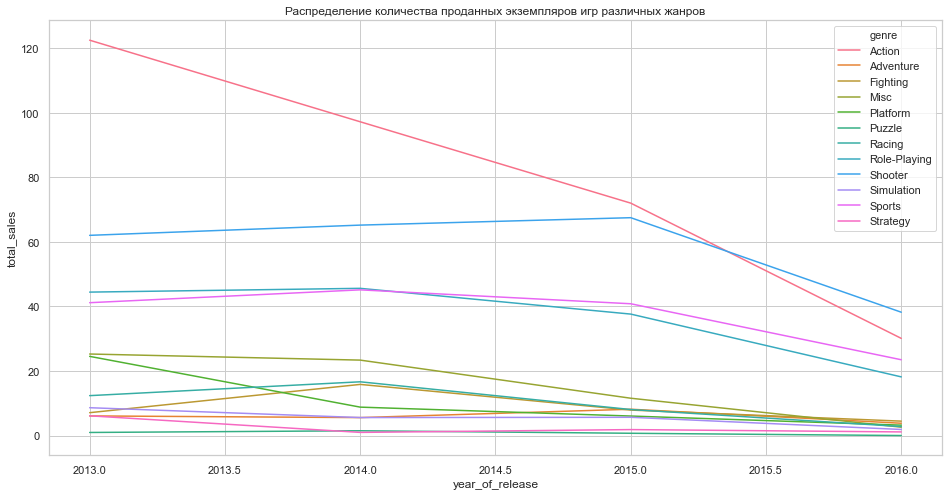

In [301]:
ax5 = sns.lineplot(data = games_season.groupby(['year_of_release', 'genre'], as_index=False).total_sales.sum(),
                  x = 'year_of_release',
                  y = 'total_sales', 
                  hue = 'genre')
ax5.set_title('Распределение количества проданных экземпляров игр различных жанров')
plt.show()

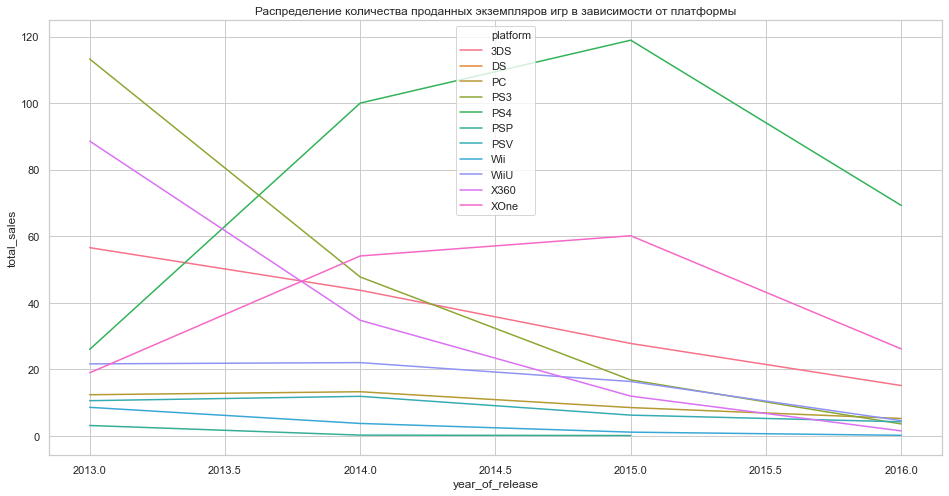

In [302]:
ax6 = sns.lineplot(data = games_season.groupby(['year_of_release', 'platform'], as_index=False).total_sales.sum(),
                  x = 'year_of_release',
                  y = 'total_sales', 
                  hue = 'platform')
ax6.set_title('Распределение количества проданных экземпляров игр в зависимости от платформы')
plt.show()

In [303]:
games_season \
    .groupby(['year_of_release', 'platform'], as_index=False) \
    .total_sales.sum() \
    .sort_values(by=['year_of_release', 'total_sales'], ascending = False) \
    .head(5)

,year_of_release,platform,total_sales
34,2016.0,PS4,69.25
39,2016.0,XOne,26.15
31,2016.0,3DS,15.14
32,2016.0,PC,5.25
37,2016.0,WiiU,4.60


Судя по графикам распределения количества проданных экземпляров игр, их количество сокращается от года к году, равномерно по всем признакам (платформа и жанр). Исходя из того, что нарастающую тенденцию выпуска количества новых игр по годам имеют платформы `PS4`, `XOne` и `PC`, они точно могут считаться перспективными для выпуска новой игры. Также к этому списку можно добавить платформу `3DS`, так как все же они продаются в большом количестве экземпляров.

### Определение самой перспективной платформы и жанра для закупки игр в 2017

Для того, чтобы определить самую перспективную платформу и жанр, необходимо сравнить средние показатели количества проданных экземпляров на одну игру.

In [304]:
# отберем интересующие нас платформы
top_plarform = ['PS4', 'XOne', 'PC', '3DS']
games_season_top = games_season.query("platform in @top_plarform")

In [305]:
# рассчитаем среднее значение проданных экземпляров на одну игру
data_platform = games_season_top \
.groupby(['year_of_release', 'platform'], as_index=False) \
.agg({'name':'count', 'total_sales':'sum'})

data_platform['mean_sales'] = round(data_platform['total_sales'] / data_platform['name'], 2)

data_platform.sort_values(by=['year_of_release', 'mean_sales'], ascending = False, inplace=True)

In [306]:
# посмотрим на данные
data_platform.pivot(index='year_of_release', columns='platform', values='mean_sales')

platform,3DS,PC,PS4,XOne
year_of_release,,,,
2013.0,0.62,0.33,1.62,1.00
2014.0,0.55,0.28,1.33,0.89
2015.0,0.32,0.17,0.87,0.75
2016.0,0.33,0.10,0.42,0.30


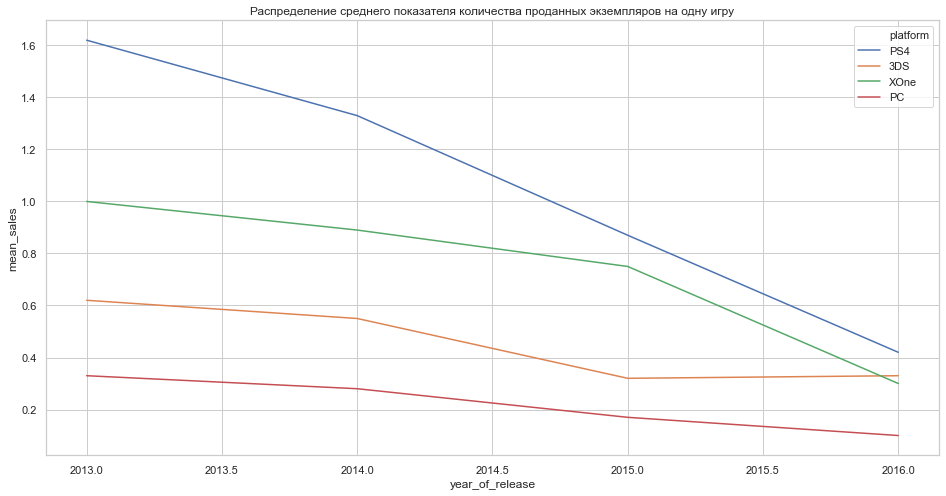

In [307]:
# отобразим получившиееся данные на графике
ax = sns.lineplot(data = data_platform,
                  x = 'year_of_release',
                  y = 'mean_sales', 
                  hue = 'platform')
ax.set_title('Распределение среднего показателя количества проданных экземпляров на одну игру')
plt.show()

Самой перспективной платформой является `PS4`, т.к. эта платформа является развивающейся, и количество проданных экземпляров на одну выпущенную игру у нее больше, чем у остальных платформ.

In [308]:
# рассчитаем среднее значение проданных экземпляров на одну игру в зависимости от жанра
data_genre = games_season_top \
.groupby(['year_of_release', 'genre'], as_index=False) \
.agg({'name':'count', 'total_sales':'sum'})

data_genre['mean_sales_genre'] = round(data_genre['total_sales'] / data_genre['name'], 2)

data_genre.sort_values(by=['year_of_release', 'mean_sales_genre'], ascending = False, inplace=True)

In [309]:
# посмотрим на данные
data_genre.pivot(index='year_of_release', columns='genre', values='mean_sales_genre')

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2013.0,0.54,0.21,0.26,0.31,0.62,0.43,0.87,1.30,1.13,0.81,0.78,0.45
2014.0,0.71,0.12,2.61,0.58,1.30,0.06,0.64,0.84,1.82,0.69,0.92,0.15
2015.0,0.43,0.24,0.47,0.29,0.13,0.14,0.57,0.68,2.16,0.41,0.91,0.13
2016.0,0.21,0.11,0.29,0.06,0.25,NaN,0.12,0.49,0.86,0.11,0.66,0.09


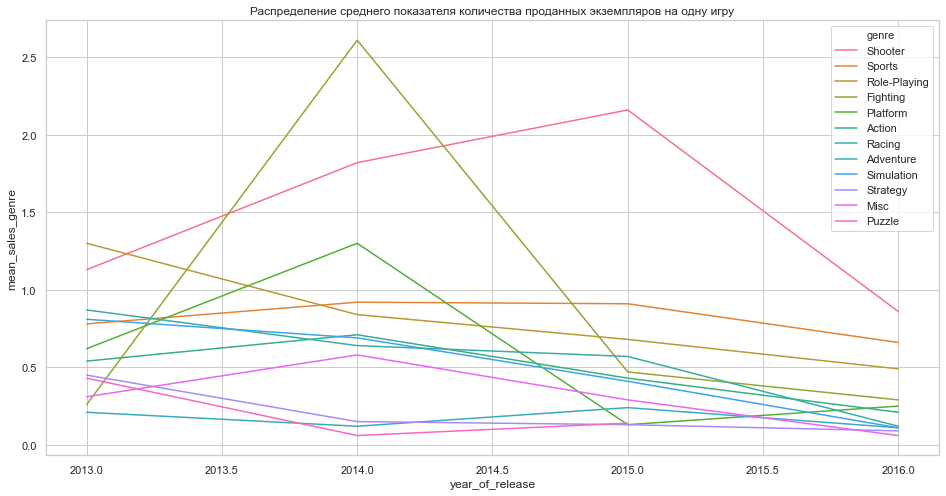

In [310]:
# отобразим получившиееся данные на графике
ax = sns.lineplot(data = data_genre,
                  x = 'year_of_release',
                  y = 'mean_sales_genre', 
                  hue = 'genre')
ax.set_title('Распределение среднего показателя количества проданных экземпляров на одну игру')
plt.show()

Самым перспективным жанром является Shooter, т.к. количество проданных экземпляров на одну выпущенную игру у нее больше, чем у остальных жанров.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

In [311]:
# отберем нужные для нас данные
games_on_ps4 = games_season_top.query("platform == 'PS4'")

In [312]:
# посмотрим на коэф. корреляции
games_on_ps4[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


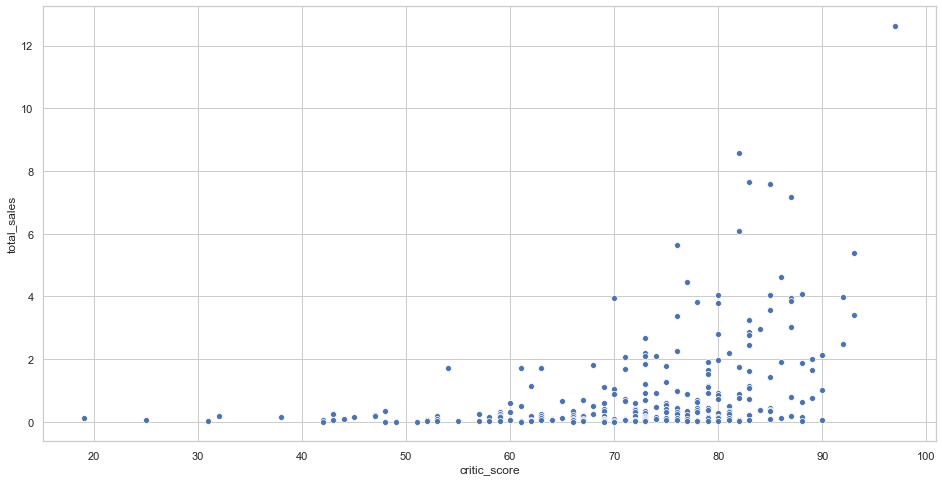

In [313]:
sns.scatterplot(data=games_on_ps4,
               x='critic_score',
               y='total_sales')

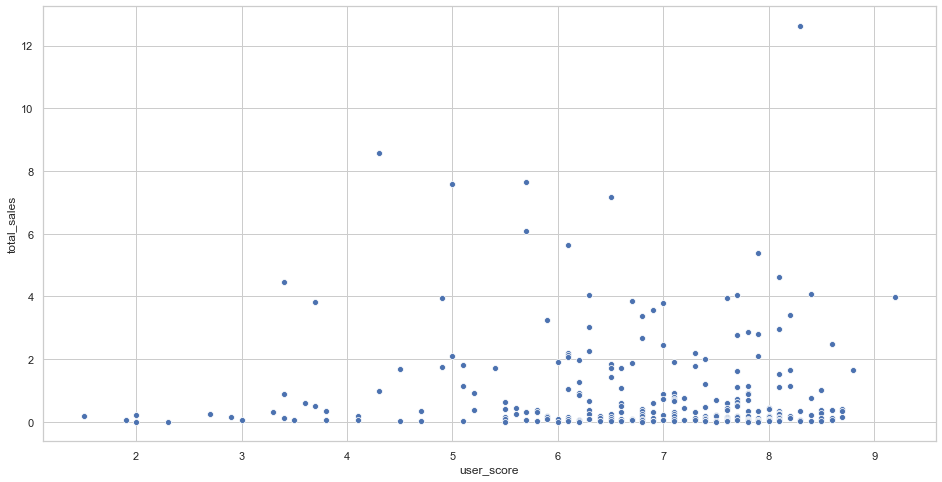

In [314]:
sns.scatterplot(data=games_on_ps4,
               x='user_score',
               y='total_sales')

Судя по графикам и коэф. корреляции, отценки критиков более четко отражают популярность игр. Отценки пользователей не имеют четкой взаимосвязи с количеством проданных игр, т.к. они оценивают только те игры, в которые играли, а играют они в большей степени в те игры, к которым они изначально лояльны. 

### Составим портрет пользователя каждой из стран

In [315]:
# 5 самых продаваемых платформ в Северной Америке за последние 4 года
na_sales_top = games_season \
                    .groupby('platform', as_index=False) \
                    .na_sales \
                    .sum() \
                    .sort_values(by='na_sales', ascending=False) \
                    .head(5) \
                    .rename(columns={'na_sales':'sales'})
na_sales_top['country'] = 'North America'

In [316]:
# 5 самых продаваемых платформ в Европе за последние 4 года
eu_sales_top = games_season \
                    .groupby('platform', as_index=False) \
                    .eu_sales \
                    .sum() \
                    .sort_values(by='eu_sales', ascending=False) \
                    .head(5) \
                    .rename(columns={'eu_sales':'sales'})
eu_sales_top['country'] = 'Europe'

In [317]:
# 5 самых продаваемых платформ в Японии за последние 4 года
jp_sales_top = games_season \
                    .groupby('platform', as_index=False) \
                    .jp_sales \
                    .sum() \
                    .sort_values(by='jp_sales', ascending=False) \
                    .head(5) \
                    .rename(columns={'jp_sales':'sales'})
jp_sales_top['country'] = 'Japan'

In [318]:
top_5_sales = na_sales_top.append(eu_sales_top).append(jp_sales_top)

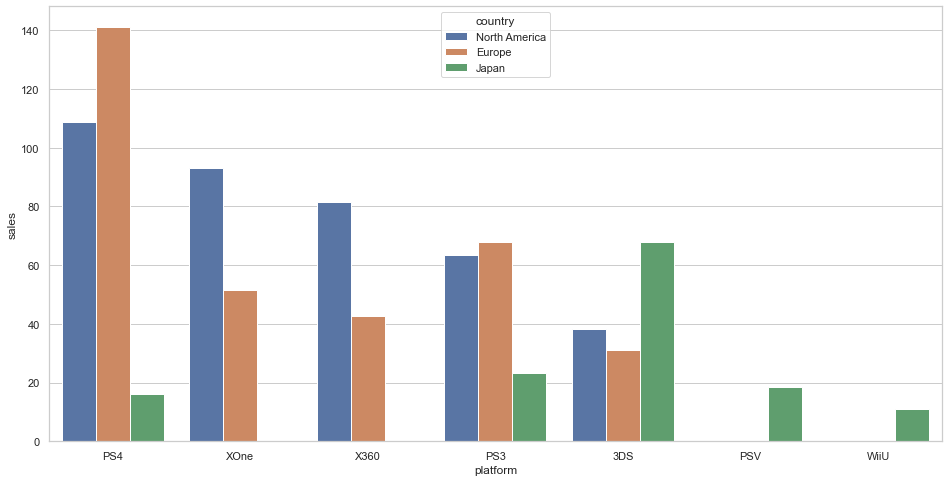

In [319]:
# посмотрим на количество продаж 5 топовых платформ для каждой страны
sns.barplot(data=top_5_sales, x='platform', y='sales', hue='country')

На графике видно, что в зависимости от страны, количество проданных игр в зависимости от платформы меняется. Тем не менее ситуация по продажам в Северной Америке и Европе не так сильно отличаются друг от друга, как от продаж в Японии. Это абусловленно менталитетом разных народов.

### Зависимость количества продаж и возрастного рейтинга в Северной Америке

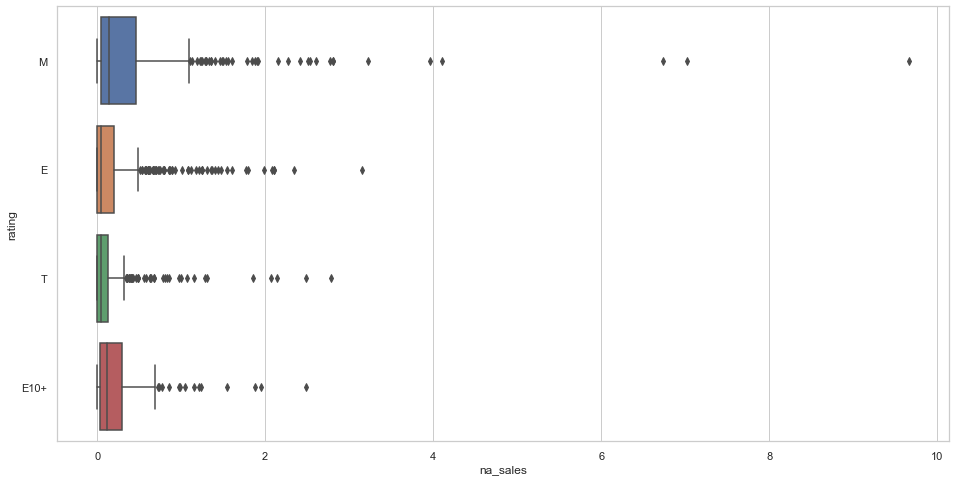

In [320]:
# посмотрим на распределение значений
sns.boxplot(data=games_season, y='rating', x='na_sales', orient='h')

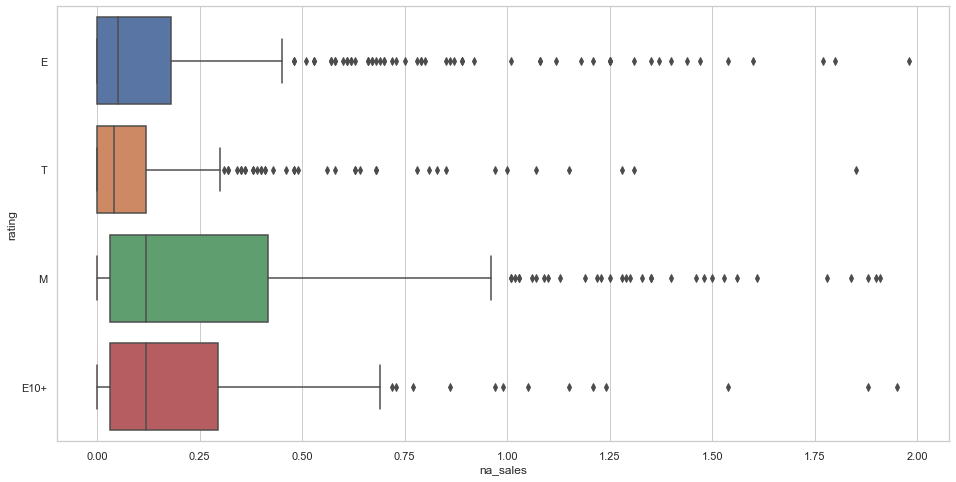

In [321]:
# избавимся от сильных выбросов, и посмотрим на график еще раз
na_games = games_season.query("na_sales < 2")[['na_sales', 'rating']]

sns.boxplot(data=na_games, y='rating', x='na_sales', orient='h')

Проведем однофакторный дисперсионный анализ ANOVA.

Проверим нулевую гипотезу о том,
что среднее хотя бы одной из групп значимо отличается от средних в других группах

In [322]:
# преобразуем наши данные
na_games = na_games.pivot(columns='rating', values='na_sales')

In [323]:
# Дисперсии внутри групп должны быть примерно равны (требование гомогенности дисперсий)
# Тест Левена проверяет нулевую гипотезу о том, что все выборки имеют равную дисперсию.
stat, p =  st.levene(na_games['E'].dropna(),
                         na_games['E10+'].dropna(), 
                         na_games['M'].dropna(),
                         na_games['T'].dropna())

In [324]:
# посмотрим на p-value
p

3.3591871321114336e-09

Вероятность получить такие или еще более значимые различия, при условии что верна нулевая гипотеза стремиться к нулю (меньше, чем 0,01%). Следовательно нам необходим непараметрический аналог дисперсионного анализа.

In [325]:
# Непараметрический тест Крускалла Волиса (аналог дисперсионного анализа)
st.kruskal(na_games['E'].dropna(),
            na_games['E10+'].dropna(), 
            na_games['M'].dropna(),
            na_games['T'].dropna())

KruskalResult(statistic=76.11096555714288, pvalue=2.0939926211744414e-16)

Вероятность получить такие или еще более значимые различия, при условии что верна нулевая гипотеза стремиться к нулю (меньше, чем 0,01%). Следовательно среднее хотя бы одной из групп значимо отличается от средних в других группах.

Проведем ранговый попарный тест Данна.

Может использоваться после одностороннего дисперсионного анализа Краскела-Уоллиса по рангам для попарных сравнений.

In [326]:
# Выполним тест Данна с поправкой Бонферонни для p-значений
sp.posthoc_dunn( [na_games['E'].dropna(),
                  na_games['E10+'].dropna(), 
                  na_games['M'].dropna(),
                  na_games['T'].dropna()],
                  p_adjust = 'bonferroni')

,1,2,3,4
1,1.000000e+00,4.080347e-03,2.396328e-07,1.323111e-01
2,4.080347e-03,1.000000e+00,5.277882e-01,8.956689e-08
3,2.396328e-07,5.277882e-01,1.000000e+00,5.599889e-15
4,1.323111e-01,8.956689e-08,5.599889e-15,1.000000e+00


Все группы значимо различаются между собой, т.к. p-value меньше 0,01

### Проверка гипотез

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?

    Нулевая гипотеза Н0: Средние обеих платформ принадлежат одной ГС.
    Альтернативная гипотеза Н1: Средние обеих платформ не равны.

In [327]:
# отберем необходимые данные
data_hyp1 = games_season \
            .query("platform == 'XOne' or platform == 'PC'")[['platform', 'user_score']] \
            .pivot(columns='platform', values='user_score')

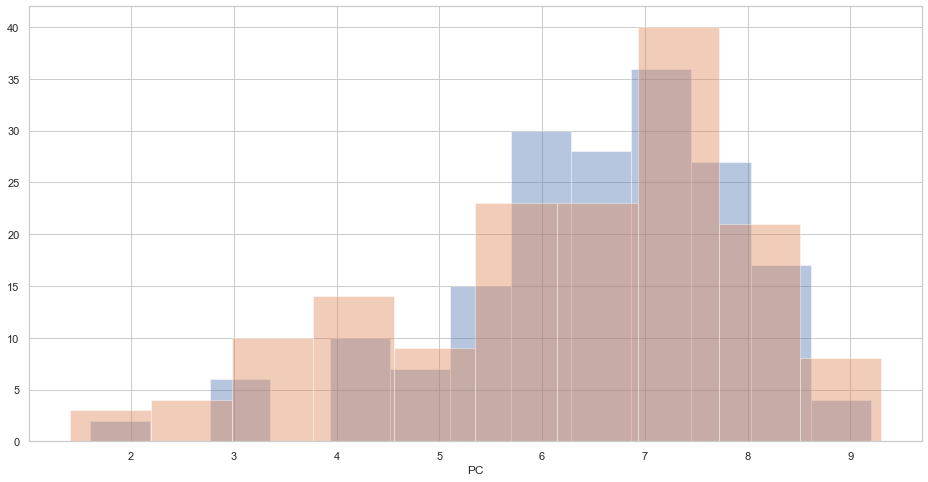

In [328]:
# посмотрим на распределения
sns.distplot(data_hyp1['XOne'], kde=False)
sns.distplot(data_hyp1['PC'], kde=False)

In [329]:
# Для проведения парного T теста, дисперсии внутри групп должны быть равны
# Тест Левена проверяет нулевую гипотезу о том, что все выборки имеют равную дисперсию.
stat, p =  st.levene(data_hyp1['XOne'].dropna(),
                     data_hyp1['PC'].dropna())

In [330]:
# посмотрим на p-value
p

0.003897553110130418

In [331]:
# Парный t-тест
stat, p =  st.ttest_ind(data_hyp1['XOne'].dropna(),
                         data_hyp1['PC'].dropna(),
                         equal_var=False)

In [332]:
# посмотрим на p-value
p

0.14759594013430463

Вероятность получить такие или еще более значимые различия, при условии что верна нулевая гипотеза составляет 14%. Мы не можем отклонить нулевую гипотезу о равенстве средних значений.

2. Средние пользовательские рейтинги жанров Action и Sports разные?

    Нулевая гипотеза Н0: Средние обоих жанров принадлежат одной ГС.
    Альтернативная гипотеза Н1: Средние обоих жанров не равны.

In [333]:
# отберем необходимые данные
data_hyp2 = games_season \
            .query("genre == 'Action' or genre == 'Sports'")[['genre', 'user_score']] \
            .pivot(columns='genre', values='user_score')

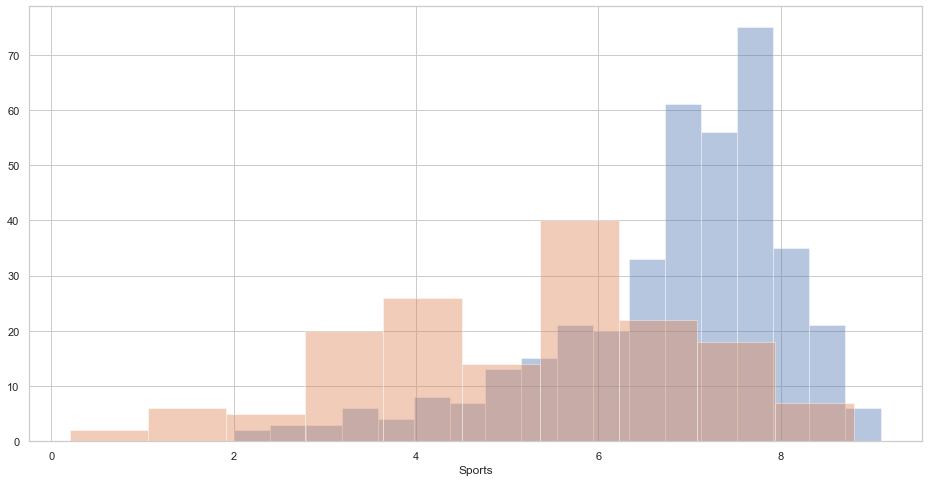

In [334]:
# посмотрим на распределения
sns.distplot(data_hyp2['Action'], kde=False)
sns.distplot(data_hyp2['Sports'], kde=False)

In [335]:
# Для проведения парного T теста, дисперсии внутри групп должны быть равны
# Тест Левена проверяет нулевую гипотезу о том, что все выборки имеют равную дисперсию.
stat, p =  st.levene(data_hyp2['Action'].dropna(),
                     data_hyp2['Sports'].dropna())

In [336]:
# посмотрим на p-value
p

4.2566688218274047e-07

In [337]:
# Парный t-тест
stat, p =  st.ttest_ind(data_hyp2['Action'].dropna(),
                         data_hyp2['Sports'].dropna(),
                         equal_var=False)

In [338]:
# посмотрим на p-value
p

1.4460039700704315e-20

Вероятность получить такие или еще более значимые различия, при условии что верна нулевая гипотеза составляет менее 0,1%. Мы можем отклонить нулевую гипотезу о равенстве средних значений разных жанров.

<a name="stage_3"></a>
# 3. Исследовательский анализ данных.


[Наверх к оглавлению](#contents)

* Средняя продолжительность выхода игр на конкретной платформе составляет 8-10 лет, из которых 3-4 года приходится на пик этой платформы по сравнению со своими прошлыми и будующими версиями. При прогнозировании спроса на следующий год, необходимо понимать на какой стадии развития находится каждая из платформ, чтобы скорректиовать покупки игр.
* В 2017 году выгоднее всего будет продавать игры на платформах: `PS4`, `XOne` и `PC`. В 2016 году хорошо продавались игры на платформе `3DS`, но в 2017 году стоит покупать только самые популярные игры для этой платформы и в небольшом количестве, т.к. эта платформа уже прошла пик своего развития и по всей вероятности скоро сменится другим поколением приставок.
* В среднем, игры жанров `Shooter`,	`Sports` и `Role-Playing` продаются лучше всего. 
* Отценки критиков хорошо отражают популярность игр, следовательно при выборе игр для закупки, следует ориентироваться именно на их отценки. Отценки пользователей не имеют четкой взаимосвязи с количеством проданных игр, т.к. скорее всего пользователи оценивают только те игры, в которые играли, а играют они в большей степени в те игры, к которым они изначально лояльны. 
* В зависимости от региона, предпочтения пользователей также изменяются. Как при выборе платформы, так и при выборе жанра игры. Так например в Европе и Северной Америке самой популярной платформой является `PS4`, а в Японии она находится аж на 4 месте по количеству проданных игр.
* В зависимости от возрастного рейтинга, предпочтения пользователей также меняются. Что в свою очередь влияет и на количество продаж. Самые частопродаваемые игры имеют рейтинг `M`, т.е. для взрослых.
* Средние пользовательские рейтинги на платформах `XOne` и `PC` статистически значимо не различаются.
* Средние пользовательские рейтинги жанров `Action` и `Sports` статистически значимо различаются.